In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

plt.style.use('mydark')

In [3]:
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

## Pulling and cleaning data

In [4]:
'''
In final iteration these should be pulling from aws SQL database
Data is precleaned, besides sclaing inside the pipleline not much to do here
'''
fraud_df = pd.read_csv('creditcard.csv')

In [5]:
#fraud_df.columns

In [6]:
# histograms of each column
# plt.figure(figsize=(15,25))
# for i in range(1,28+1):
#     plt.subplot(7,4,i)
#     index = 'V{}'.format(i)
#     plt.hist(fraud_df[index],bins = 30)

In [7]:
# goal was to create a giant pairplot but thi sis too slow.  maybe try again later
# import seaborn as sns
# sns.pairplot(fraud_df,hue='Class').savefig('pplot.png')

In [8]:
X = fraud_df.iloc[:,1:-1]
y = fraud_df.Class

np.random.seed(7) #consistency across results, prevents leaking when loading pickled models

X_train,X_test,y_train,y_test=train_test_split(X,y)

In [9]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(ratio=0.1,random_state=42)
X_res, y_res = smt.fit_sample(X_train, y_train)

# from imblearn.combine import SMOTEENN
# sme = SMOTEENN(ratio=0.1,random_state=42)
# X_res, y_res = sme.fit_sample(X_train, y_train)

print(len(X_train),len(X_res))
print(np.count_nonzero(y_res))
X_train,y_train=X_res,y_res

213605 234551
21323


In [10]:
# attempt to oversample or undersample the data here
# might not matter depending on algorithm


## Define Pipelines

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier

def create_model():
    #define keras model
    model = Sequential()
    model.add(Dense(10, input_dim=29, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model
keras_est = KerasClassifier(build_fn=create_model, nb_epoch=10, batch_size=400, verbose=1)
#create custom metric for recall accuracy later

Using TensorFlow backend.


In [12]:
estimators = [ #array of pipelines
    #logistic regression
    Pipeline([('scaler',StandardScaler()),
              ('estimator',LogisticRegression())]),
    #Naive Bayes
    Pipeline([('scaler',StandardScaler()),
              ('estimator',LogisticRegression())]),
    #random forests
    Pipeline([('scaler',StandardScaler()),
              ('estimator',RandomForestClassifier())]),
#     #support vector machines (SVM)
#     Pipeline([('scaler',StandardScaler()),
#               ('estimator',SVC(probability=False))]),
    #gradient boosting
    Pipeline([('scaler',StandardScaler()),
              ('estimator',GradientBoostingClassifier())]),
    #multilayer perceptron from sklearn
    Pipeline([('scaler',StandardScaler()),
              ('estimator',MLPClassifier())]),
#     #neural net from keras
#     Pipeline([('scaler',StandardScaler()),
#               ('estimator',keras_est)])
]
est_labels=[
    'Logistic Regression',
    'Naive Bayes',
    'Random Forest',
#     'SVM',
    'Gradient Boost',
    'Multi-Layer Perceptron', #default 
#     'KerasNN', #need to use keras
    'Democratic Meta',
    'Weighted Meta'
]
#define everything else as for est in estimators

In [13]:
parameters = [
{ #logistic regression
    'estimator__C':(0.5,1,2),
    #'estimator__solver':('liblinear','sag'),
    'estimator__tol':(1e-4,1e-3)
},
{ #naive Bayes, nothing to adjust
},
{ #Random Forest
    'estimator__n_estimators':(10,5),
    'estimator__max_features':('sqrt',None),
    'estimator__min_samples_split':(2,4),
    'estimator__min_samples_leaf':(1,2)
},
# { #SVM
#     #'estimator__tol':(1e-4,1e-3)
# },
{ #GradBoost
    'estimator__learning_rate':(0.1,0.2),
    'estimator__max_depth':(3,4),
    'estimator__min_samples_split':(2,3),
    'estimator__max_features':('sqrt','log2')
},
{ #MLP
    'estimator__activation':('relu','tanh'),
    'estimator__alpha':(0.0001,0.0002),
    'estimator__learning_rate':('constant','adaptive')
}
]

In [14]:
grids = [GridSearchCV(estimators[i],parameters[i], n_jobs=-1) 
         for i in range(len(estimators))
#     GridSearchCV(estimators[0],parameters[0], n_jobs=-1), #logR
#     GridSearchCV(estimators[1],parameters[1], n_jobs=-1), #NaiveBayes
#     GridSearchCV(estimators[2],parameters[2], n_jobs=-1), #RandFor
#     #GridSearchCV(estimators[3],parameters[3], n_jobs=-1), #SVM
#     GridSearchCV(estimators[3],parameters[3], n_jobs=-1), #GradBoost
#     GridSearchCV(estimators[4],parameters[4], n_jobs=-1) #MLP
]

In [15]:
estimators=grids
#dumb but this should work

In [16]:
# train estimators, use gridsearchcv where applicable for hyperparameters
# define single training function so any train/test splits are done automatically
# hyperparameters will have to be tuned on per model basis

In [17]:
import pickle
pickled = True #set true to load serialized version and save computation time

In [18]:
#training step, takes awhile for some models
#use retrain_models to iterate on a single model 
if pickled:
    #load estimators, y_preds from file
    estimators=pickle.load(open('modelsFINAL.pkl','rb'))
    print('loaded trained estimators from file')
else:
    pickled=True
    for i,est in enumerate(estimators):
        est.fit(X_train,y_train)
        #y_preds[i]=est.predict(X_test)
        print('completed training {} model'.format(est_labels[i]))

loaded trained estimators from file


In [19]:
#method for retraining a single model, useful for tinkering

def retrain_model(name='Gradient Boost'): #name of model to be retrained
    index = est_labels.index(name)
    estimators[index].fit(X_train,y_train)
    y_preds[index]=estimators[index].predict(X_test)
    print('completed training {} model'.format(name))

In [20]:
#predict models
y_preds=[None]*len(estimators)
#print(len(y_preds),len(estimators))
for i,est in enumerate(estimators):
    #est.fit(X_train,y_train)
    y_preds[i]=est.predict(X_test)

In [21]:
#this sets up recall scores for the weighted meta classifier

from sklearn.metrics import recall_score
recallscores=list()
for i,est in enumerate(estimators):
    recallscores.append(recall_score(y_test,y_preds[i]))
# pprint.pprint(list(zip(est_labels,recallscores)))

In [22]:
#Define voting Classifiers
from sklearn.ensemble import VotingClassifier
if pickled:
    pass
else:
    balanced=VotingClassifier(list(zip(est_labels,estimators))[:],
                              voting='soft')
    balanced.fit(X_train,y_train)
    biased=VotingClassifier(list(zip(est_labels,estimators))[:],voting='soft',
                            weights=recallscores)
    biased.fit(X_train,y_train)
    while len(estimators)<len(est_labels):
        estimators.append(None)
    while len(y_preds)<len(estimators):
        y_preds.append(None)
    y_preds[est_labels.index('Democratic Meta')]=balanced.predict(X_test)
    y_preds[est_labels.index('Weighted Meta')]=biased.predict(X_test)
    estimators[est_labels.index('Democratic Meta')]=balanced
    estimators[est_labels.index('Weighted Meta')]=biased

/Users/gpatient/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/gpatient/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/gpatient/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/gpatient/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/gpatient/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1

In [23]:
#dump estimators


# TypeError: can't pickle _thread.lock objects
# started when keras model was added zz
pickle.dump(estimators,open('modelsFINAL.pkl','wb'))

## Define plots

In [24]:
from sklearn.metrics import recall_score, precision_score, f1_score
def metric_print(metric_name,metric_score,true,predicted):
    scores=list()
    print('{} scores by model:'.format(metric_name))
    for i,est in enumerate(estimators):
        scores.append(metric_score(true,predicted[i]))
        print(est_labels[i]+': {:.4f}'.format(scores[i]))
    print('')
    return(scores)

AUPRC scores by model
Logistic Regression: 0.7906
Naive Bayes: 0.7906
Random Forest: 0.8599
Gradient Boost: 0.7933
Multi-Layer Perceptron: 0.8267
Democratic Meta: 0.8571
Weighted Meta: 0.8568


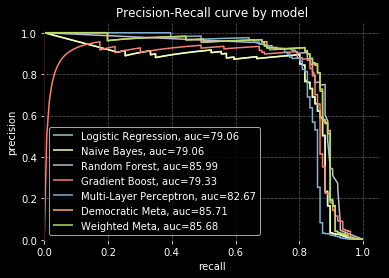

In [25]:
#precision-recall and area under curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
print('AUPRC scores by model')
for i,est in enumerate(estimators):
    try:
        #plot recision_recall curve w/classifier label
        y_proba=est.predict_proba(X_test)[:,1]
        precision, recall, _ = precision_recall_curve(y_test,y_proba)
        auc=average_precision_score(y_test,y_proba)
        print(est_labels[i]+': {:.4f}'.format(auc))
        plt.plot(recall, precision,label=est_labels[i]+', auc={:.2f}'.format(auc*100))
    except:
        #can't get probabilities from all classifiers
        pass
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve by model')
plt.xlim(0,1.05)
plt.ylim(0,1.05);
# pprint.pprint(list(zip(est_labels,f1scores)))

AUC scores by model
Logistic Regression: 0.9729
Naive Bayes: 0.9730
Random Forest: 0.9628
Gradient Boost: 0.9780
Multi-Layer Perceptron: 0.9552
Democratic Meta: 0.9807
Weighted Meta: 0.9806


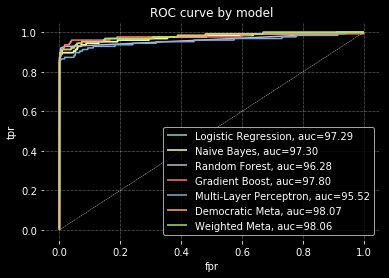

In [26]:
#ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
print('AUC scores by model')
for i,est in enumerate(estimators):
    try:
        #plot recision_recall curve w/classifier label
        y_proba=est.predict_proba(X_test)[:,1]
        fpr, tpr, thr = roc_curve(y_test, y_proba)
        auc=roc_auc_score(y_test,y_proba)
        print(est_labels[i]+': {:.4f}'.format(auc))
        plt.plot(fpr, tpr,label=est_labels[i]+', auc={:.2f}'.format(auc*100))
    except:
        #can't get probabilities from all classifiers
        pass
plt.plot([0, 1], [0, 1],color='w', linestyle='--', linewidth=.4)
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve by model')
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05);

In [27]:
from sklearn.metrics import recall_score
recallscores=list()
print('recall scores by model')
for i,est in enumerate(estimators):
    recallscores.append(recall_score(y_test,y_preds[i]))
    print(est_labels[i]+': {:.4f}'.format(recallscores[i]))
# pprint.pprint(list(zip(est_labels,recallscores)))

recall scores by model
Logistic Regression: 0.8810
Naive Bayes: 0.8810
Random Forest: 0.8413
Gradient Boost: 0.8492
Multi-Layer Perceptron: 0.8254
Democratic Meta: 0.8651
Weighted Meta: 0.8651


In [28]:
from sklearn.metrics import f1_score
f1scores=list()
print('f1 scores by model')
for i,est in enumerate(estimators):
    f1scores.append(f1_score(y_test,y_preds[i]))
    print(est_labels[i]+': {:.4f}'.format(f1scores[i]))

f1 scores by model
Logistic Regression: 0.5968
Naive Bayes: 0.5984
Random Forest: 0.8281
Gradient Boost: 0.7839
Multi-Layer Perceptron: 0.8000
Democratic Meta: 0.8104
Weighted Meta: 0.8044


In [29]:
print('Metrics for test set:\n')
metric_print('recall',recall_score,y_test,y_preds)
metric_print('precision',precision_score,y_test,y_preds)
metric_print('f1',f1_score,y_test,y_preds);

Metrics for test set:

recall scores by model:
Logistic Regression: 0.8810
Naive Bayes: 0.8810
Random Forest: 0.8413
Gradient Boost: 0.8492
Multi-Layer Perceptron: 0.8254
Democratic Meta: 0.8651
Weighted Meta: 0.8651

precision scores by model:
Logistic Regression: 0.4512
Naive Bayes: 0.4531
Random Forest: 0.8154
Gradient Boost: 0.7279
Multi-Layer Perceptron: 0.7761
Democratic Meta: 0.7622
Weighted Meta: 0.7517

f1 scores by model:
Logistic Regression: 0.5968
Naive Bayes: 0.5984
Random Forest: 0.8281
Gradient Boost: 0.7839
Multi-Layer Perceptron: 0.8000
Democratic Meta: 0.8104
Weighted Meta: 0.8044



In [67]:
def calc_cost(truth, pred, cost):
    dumber= zip(truth,pred,cost)
    total=0
    for dumb in dumber:
        if np.abs(dumb[0]-dumb[1])>0.5:
            total+=dumb[2]
    return total

In [69]:
for i in range(len(y_preds)):
    print(est_labels[i],
          calc_cost(y_test,y_preds[i],X_test.Amount))
print('loss without model:',calc_cost(y_test,[0 for _ in y_test],X_test.Amount))

Logistic Regression 94048.72
Naive Bayes 94045.24
Random Forest 6405.31
Gradient Boost 14435.02
Multi-Layer Perceptron 7962.14
Democratic Meta 32223.85
Weighted Meta 32314.61
loss without model: 16239.76


In [56]:
print(type(y_preds[0]))
print(type(y_test))
print(type(X_test.Amount))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### below plots generated with training data as comparision

In [30]:
y_preds_train=[None]*len(estimators)
#print(len(y_preds_train),len(estimators))
for i,est in enumerate(estimators):
    #est.fit(X_train,y_train)
    y_preds_train[i]=est.predict(X_train)

AUPRC scores by model
Logistic Regression: 0.9651
Naive Bayes: 0.9651
Random Forest: 1.0000
Gradient Boost: 0.9993
Multi-Layer Perceptron: 1.0000
Democratic Meta: 0.9998
Weighted Meta: 0.9998
AUC scores by model
Logistic Regression: 0.9911
Naive Bayes: 0.9911
Random Forest: 1.0000
Gradient Boost: 0.9999
Multi-Layer Perceptron: 1.0000
Democratic Meta: 1.0000
Weighted Meta: 1.0000


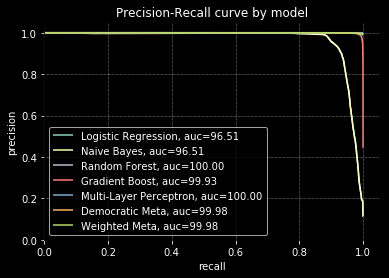

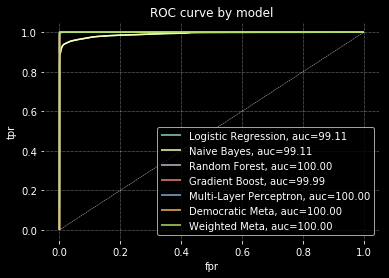

In [31]:
#precision-recall and area under curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
print('AUPRC scores by model')
for i,est in enumerate(estimators):
    try:
        #plot recision_recall curve w/classifier label
        y_proba=est.predict_proba(X_train)[:,1]
        precision, recall, _ = precision_recall_curve(y_train,y_proba)
        auc=average_precision_score(y_train,y_proba)
        print(est_labels[i]+': {:.4f}'.format(auc))
        plt.plot(recall, precision,label=est_labels[i]+', auc={:.2f}'.format(auc*100))
    except:
        #can't get probabilities from all classifiers
        pass
plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall curve by model')
plt.xlim(0,1.05)
plt.ylim(0,1.05);
# pprint.pprint(list(zip(est_labels,f1scores)))

#ROC curve
plt.figure()
from sklearn.metrics import roc_curve, roc_auc_score
print('AUC scores by model')
for i,est in enumerate(estimators):
    try:
        #plot recision_recall curve w/classifier label
        y_proba=est.predict_proba(X_train)[:,1]
        fpr, tpr, thr = roc_curve(y_train, y_proba)
        auc=roc_auc_score(y_train,y_proba)
        print(est_labels[i]+': {:.4f}'.format(auc))
        plt.plot(fpr, tpr,label=est_labels[i]+', auc={:.2f}'.format(auc*100))
    except:
        #can't get probabilities from all classifiers
        pass
plt.plot([0, 1], [0, 1],color='w', linestyle='--', linewidth=.4)
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve by model')
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05);

# from sklearn.metrics import f1_score
# f1scores=list()
# print('f1 scores by model')
# for i,est in enumerate(estimators):
#     f1scores.append(f1_score(y_train,y_preds_train[i]))
#     print(est_labels[i]+': {:.4f}'.format(f1scores[i]))

# from sklearn.metrics import recall_score
# recallscores=list()
# print('recall scores by model')
# for i,est in enumerate(estimators):
#     recallscores.append(recall_score(y_train,y_preds_train[i]))
#     print(est_labels[i]+': {:.4f}'.format(recallscores[i]))
# # pprint.pprint(list(zip(est_labels,recallscores)))

In [32]:
print('Metrics for training set:')
print('')
metric_print('recall',recall_score,y_train,y_preds_train)
print('')
metric_print('precision',precision_score,y_train,y_preds_train)
print('')
metric_print('f1',f1_score,y_train,y_preds_train);

Metrics for training set:

recall scores by model:
Logistic Regression: 0.8883
Naive Bayes: 0.8882
Random Forest: 0.9984
Gradient Boost: 0.9729
Multi-Layer Perceptron: 1.0000
Democratic Meta: 0.9718
Weighted Meta: 0.9683


precision scores by model:
Logistic Regression: 0.9804
Naive Bayes: 0.9804
Random Forest: 0.9992
Gradient Boost: 0.9967
Multi-Layer Perceptron: 0.9995
Democratic Meta: 0.9982
Weighted Meta: 0.9980


f1 scores by model:
Logistic Regression: 0.9321
Naive Bayes: 0.9321
Random Forest: 0.9988
Gradient Boost: 0.9847
Multi-Layer Perceptron: 0.9997
Democratic Meta: 0.9848
Weighted Meta: 0.9829



## 